In [2]:
%matplotlib inline
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import shutil
import cv2
import time
import pandas as pd
import numpy as np
import json

from PIL import Image
import torch
import torchvision
import torchvision.transforms as T

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

In [3]:
with open(r"C:\Users\USER\Desktop\TrafficLight\Dataset\train_dataset\train.json") as f:
    data_dict = json.load(f)

# Create a list containing the data rows of the table
data = []

# Loop through the elements in the annotations list
for annotation in data_dict['annotations']:
    # Get general bounding box information
    filename = annotation['filename']
    xmin = annotation['bndbox']['xmin']
    ymin = annotation['bndbox']['ymin']
    xmax = annotation['bndbox']['xmax']
    ymax = annotation['bndbox']['ymax']

    if annotation['inbox']:
        for inbox in annotation['inbox']:
            color = inbox['color']
            data.append({
                    'filename': filename,
                    'xmin': xmin,
                    'ymin': ymin,
                    'xmax': xmax,
                    'ymax': ymax,
                    'color': color,
                })


In [4]:
train_path =r'C:\Users\USER\Desktop\TrafficLight\Dataset\train_dataset\train_images'
test_path =r'C:\Users\USER\Desktop\TrafficLight\Dataset\test_dataset\test_images'

In [5]:
df = pd.DataFrame(data)
df.to_csv('traffic_lights.csv', index=False)

In [6]:
data_tf = pd.read_csv(r'C:\Users\USER\Desktop\TrafficLight\traffic_lights.csv')
data_tf['filename'] = data_tf['filename'].str.replace('train_images\\\\', '', regex=True)
data_tf.to_csv('traffic_lights_labels.csv', index=False)
df = pd.read_csv(r'C:\Users\USER\Desktop\TrafficLight\traffic_lights_labels.csv')
print(df)

       filename    xmin    ymin    xmax    ymax  color
0     00001.jpg  1026.5   741.8  1077.5   910.9    red
1     00002.jpg  1418.7  1136.8  1428.3  1149.4    red
2     00003.jpg  2574.3   868.7  2632.3   887.1    red
3     00003.jpg  2252.1   899.6  2300.8   918.7  green
4     00004.jpg   833.3  1163.2   843.6  1184.8  green
...         ...     ...     ...     ...     ...    ...
9417  03000.jpg    78.8  1001.7   107.7  1033.1    red
9418  03000.jpg  1234.8  1058.4  1251.0  1096.4  green
9419  03000.jpg  1264.9  1068.1  1287.6  1086.1  green
9420  03000.jpg  1296.0  1056.6  1311.7  1096.2  green
9421  03000.jpg  1346.5  1057.5  1360.8  1096.6  green

[9422 rows x 6 columns]


In [7]:
classes = df["color"].unique()
print("Total Classes: ",len(classes))
print("\n> Classes <\n",classes)

Total Classes:  3

> Classes <
 ['red' 'green' 'yellow']


<Axes: title={'center': 'Class Distribution'}, xlabel='color', ylabel='count'>

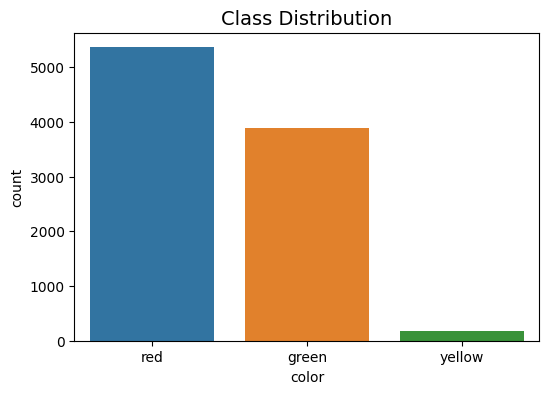

In [8]:
plt.figure(figsize=(6, 4))
plt.title('Class Distribution', fontsize= 14)
sns.countplot(x = "color", data = df)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


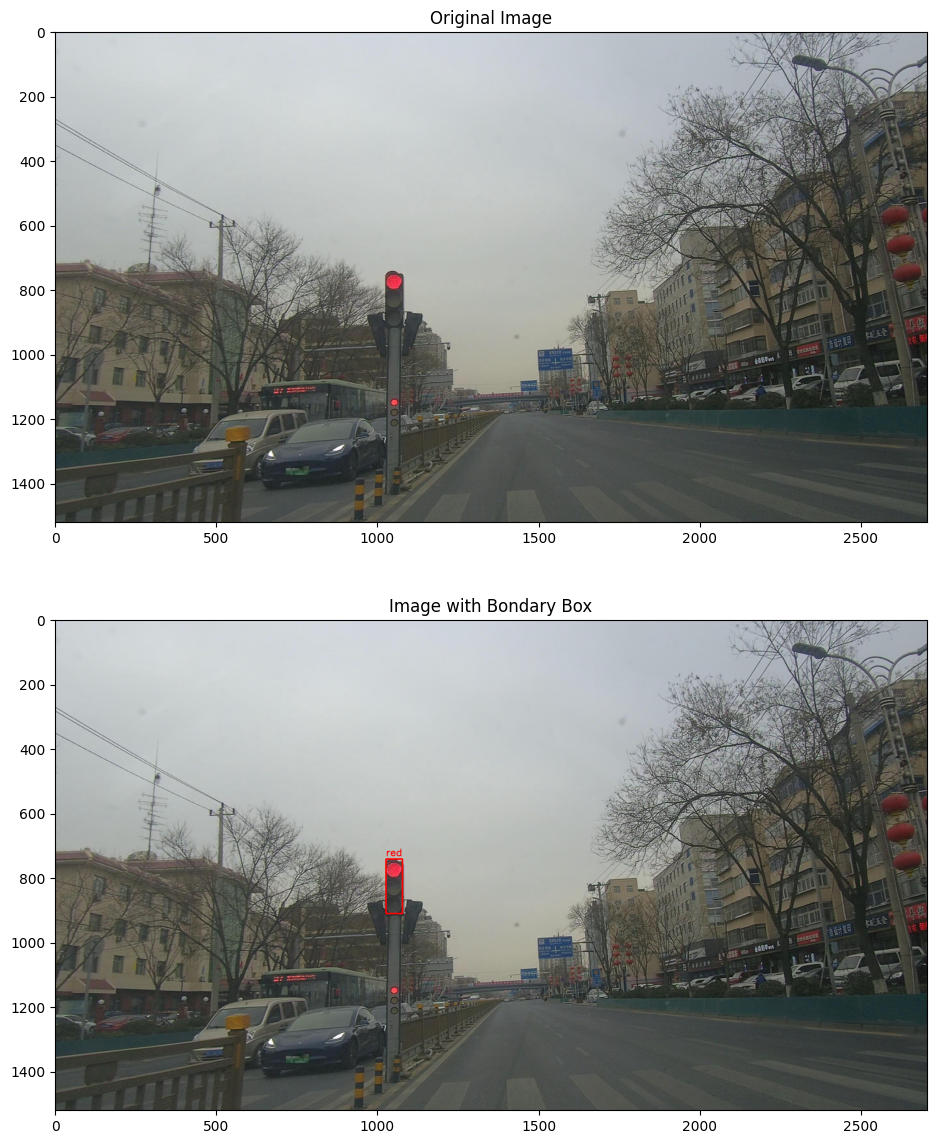

In [9]:
def plot_img(image_name):

    fig, ax = plt.subplots(2, 1, figsize = (14, 14))
    ax = ax.flatten()

    bbox = df[df['filename'] == image_name]
    img_path = os.path.join(train_path, image_name)

    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    image2 = image

    ax[0].set_title('Original Image')
    ax[0].imshow(image)

    for idx, row in bbox.iterrows():
        x1 = row['xmin']
        y1 = row['ymin']
        x2 = row['xmax']
        y2 = row['ymax']
        label = row['color']
        if label == 'red':
            color_brg = (255,0,0)
        elif label == 'green':
            color_brg = (0,255,0)
        elif label == 'yellow':
            color_brg = (0,255,255)

        cv2.rectangle(image2, (int(x1),int(y1)), (int(x2),int(y2)), color_brg, 3)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(image2, label, (int(x1),int(y1-10)), font, 1, color_brg, 2)

    ax[1].set_title('Image with Bondary Box')
    ax[1].imshow(image2)

    plt.show()
plot_img("00001.jpg")

In [10]:
_classes = np.insert(classes, 0, "background", axis=0)
class_to_int = {_classes[i] : i for i in range(len(_classes))}
int_to_class = {i : _classes[i] for i in range(len(_classes))}
print("class_to_int : \n",class_to_int)
print("\nint_to_class : \n",int_to_class)

class_to_int : 
 {'background': 0, 'red': 1, 'green': 2, 'yellow': 3}

int_to_class : 
 {0: 'background', 1: 'red', 2: 'green', 3: 'yellow'}


In [11]:
#from torch.utils.data import Dataset

class TrafficLightDetectionDataset(Dataset):

    def __init__(self, dataframe, image_dir, mode='train', transforms=None, resize_factor=0.25):

        super().__init__()

        self.image_names = dataframe['filename'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        self.mode = mode
        self.resize_factor = resize_factor

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, index: int):

        #Retrive Image name and its records (x1, y1, x2, y2, classname) from df
        image_name = self.image_names[index]
        records = self.df[self.df['filename'] == image_name]

        #Loading Image
        image = cv2.imread(self.image_dir + image_name, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        if self.mode == 'train':

            #Get bounding box co-ordinates for each box
            boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values

            #Getting labels for each box
            temp_labels = records[['color']].values
            labels = []
            for label in temp_labels:
                label = class_to_int[label[0]]
                labels.append(label)

            #Converting boxes & labels into torch tensor
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)

            # Resize the image and the bounding boxes
            height, width, _ = image.shape
            new_height, new_width = int(height * self.resize_factor), int(width * self.resize_factor)
            image = cv2.resize(image, (new_width, new_height))
            boxes = boxes * self.resize_factor
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

            #Creating target
            target = {}
            target['boxes'] = boxes
            target['labels'] = labels
            target['area'] = torch.as_tensor(area, dtype=torch.float32)

            #Transforms
            if self.transforms:
                image = self.transforms(image)


            return image, target, image_name

        elif self.mode == 'test':
            # Resize the image
            height, width, _ = image.shape
            new_height, new_width = int(height * self.resize_factor), int(width * self.resize_factor)
            image = cv2.resize(image, (new_width, new_height))

            if self.transforms:
                image = self.transforms(image)

            return image, image_name

# Preparing data for Train & Validation

def get_transform():
    return T.Compose([T.ToTensor()])

def collate_fn(batch):
    images, targets, image_names = zip(*batch)

    # Check if it's a training batch or a testing batch
    if targets[0] is not None:
        return torch.stack(images), targets, image_names
    else:
        return torch.stack(images), image_names



#trainpathh=r"C:\Users\USER\Desktop\TrafficLight\Dataset\train_dataset\train_images"
# Dataset object
dataset = TrafficLightDetectionDataset(df, train_path, transforms = get_transform())


# split the dataset in train and test set - using 80% for training, 20% for validation
indices = torch.randperm(len(dataset)).tolist()
train_dataset = torch.utils.data.Subset(dataset, indices[:-490])
valid_dataset = torch.utils.data.Subset(dataset, indices[-490:])


# Preparing data loaders
train_data_loader = DataLoader(
    train_dataset,
    batch_size = 2,
    shuffle = True,
    num_workers = 2,
    collate_fn = collate_fn
)


valid_data_loader = DataLoader(
    valid_dataset,
    batch_size = 2,
    shuffle = True,
    num_workers = 2,
    collate_fn = collate_fn
)

In [12]:
import torch
import torch.nn as nn

class YourModel(nn.Module):
    def __init__(self, num_classes):
        super(YourModel, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 64 * 64, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        # Convolutional layers
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)

        # Flatten the output for fully connected layers
        x = x.view(-1, 128 * 64 * 64)

        # Fully connected layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x


In [13]:
import torch.optim as optim

# Instantiate the model
model = YourModel(num_classes=3)  # Adjust num_classes based on your problem

# Choose the loss function and optimizer
criterion = nn.SmoothL1Loss()  # You can choose a different loss function
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training loop
num_epochs = 5  # Adjust the number of epochs as needed
for epoch in range(num_epochs):
    running_loss = 0.0
    train_loss = []

    for i, data in enumerate(train_data_loader, 0):
        inputs, targets, _ = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # Average loss
        loss_value = loss.item()
        train_loss.append(loss_value)

        # Print statistics every 200 batches
        running_loss += loss.item()
        if i % 200 == 199:  # Print every 200 mini-batches
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 200:.3f}')
            running_loss = 0.0

    epoch_train_loss = np.mean(train_loss)
    print(f'Epoch: {epoch+1}')
    print(f'Epoch train loss is {epoch_train_loss:.4f}')
    
print('Finished Training')

# Save the trained model
torch.save(model.state_dict(), 'your_model.pth')


In [ ]:
model = YourModel(num_classes=3)  # Adjust num_classes based on your problem
model.load_state_dict(torch.load('your_model.pth'))
model.eval()

In [ ]:
test_data_loader = DataLoader(
    test_path,
    batch_size=2,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)

In [ ]:
predictions = []
targets = []

with torch.no_grad():
    for i, test_data in enumerate(test_data_loader, 0):
        test_inputs, test_targets, _ = test_data

        # Forward pass
        outputs = model(test_inputs)

        # Store predictions and targets for later evaluation
        predictions.extend(outputs.cpu().numpy())
        targets.extend(test_targets.cpu().numpy())


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

predictions = np.argmax(predictions, axis=1)
targets = np.array(targets)

accuracy = accuracy_score(targets, predictions)
precision = precision_score(targets, predictions, average='macro')
recall = recall_score(targets, predictions, average='macro')
f1 = f1_score(targets, predictions, average='macro')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


In [ ]:
# Create / load model

# Faster - RCNN Model - pretrained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None, weights_backbone=None)
num_classes = len(class_to_int)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
# Preparing model for training

# Retriving all trainable parameters from model (for optimizer)
params = [p for p in model.parameters() if p.requires_grad]
# Defininig Optimizer
optimizer = torch.optim.Adam(params, lr = 0.0001)
# LR
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
model.to(device)
# No of epochs
epochs = 2

In [ ]:
# Training model

itr = 1
total_train_loss = []
for epoch in range(epochs):
    start_time = time.time()
    train_loss = []
    for images, targets, image_names in tqdm(train_data_loader):
        # tqdm 
        
        # Loading images & targets on device
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Forward propagation
        out = model(images, targets)
        losses = sum(loss for loss in out.values())
        
        # Reseting Gradients
        optimizer.zero_grad()
        
        # Back propagation
        losses.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        
        # Average loss
        loss_value = losses.item()
        train_loss.append(loss_value)
        
        if itr % 300 == 0:
            print(f"\n Iteration #{itr} loss: {loss_value:.4f} \n") ## {out}
        itr += 1
    lr_scheduler.step() 

    epoch_train_loss = np.mean(train_loss)
    total_train_loss.append(epoch_train_loss)
    print(f'Epoch: {epoch+1}')
    print(f'Epoch train loss is {epoch_train_loss:.4f}')

    
    time_elapsed = time.time() - start_time
    print("Time elapsed: ",time_elapsed)
    
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_train_loss
            }, "checkpoint.pth")
    #model=load_model('RCNNClassifier.h5')